# YOLOv3 

# Section 1 - Introduction & Setup

Suggested model and approach for pointcloud navigation and POI capture using YOLOv3 classification.

**Optimization Parameters**  
- Optimization Learning Rate: 1e-4  
- Optimization Momentum: 0.9  

**Data Parameters**  
- Batch Size: 16  
- Number of Epochs = 20    

- Image resize = 416  

**Thresholding Parameters**  
- IoU Factor = 0.2                       
- NMS Threshold = 0.2  
- IoU Epsilon = 1e-6

## 1.1: Library Imports

In [1]:
## ----------------------------
## == | Library Imports | == ##
## ----------------------------

## -- Albumentations, TensorV2 | 
import albumentations as A
from albumentations.pytorch import ToTensorV2

## -- OpenCV | Computer vision, used in bordering 
import cv2

## -- MatLab PyPlot | Result & Data Visualisation 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## -- NumPy | Statistics & Array Manipulation
import numpy as np

## -- Open3D | Pointcloud Visualisation & Interaction 
import open3d as open3d

## -- OS | IO/File Sys Interaction
import os

## -- Pandas | CSV Interaction 
import pandas as pd

## -- PIL/Image | Image handling
from PIL import Image 
#ImageFile.LOAD_TRUNCATED_IMAGES = True

## -- PyTorch | Core module, neural net, optimization & functional modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## -- Torchvision | Core module and transforms
import torchvision
from torchvision import transforms

## -- tqdm | Used for progress bar for model training
from tqdm import tqdm

import math

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1.2 - Imports Optional

In [2]:
## -- PacMan Helper | Utility Support Methods [14]
import PacMan_Helper as PacMan

import local_dataset as local_dataset
import local_model as local_model
#import local_training as local_training
import local_utility as local_utility

/home3/xccz21/myjupyterenv/lib/python3.8/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


## 1.3: Global Variables

- Base Transform: Image transform config used for resizing the given image prior to applying the model


- Load Model: Toggle for using pretrained model
- Num Epochs: Amount of epochs/count for running the training loop
- Global Learning Rate: Variable for learning rate to be used (0.0001)


- Filename: Filepath for pre-trained model


- Image size: Size that image will be resized to: img_size*img_size
- Number of classes: Number of classes in model (not including background)
- Batch size: Training batch size

- Episode: IoU episilon

In [55]:
## -- Base Transform - Used in initial resizing of dataset images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 416)),  
    transforms.ToTensor()
])

## -- Model vars
load_model = True
num_epochs = 20
gbl_lr = 1e-4

## -- Model filepath
filename="model.pth.tar"

## -- Model vars
image_size = 416   
num_classes = 1
batch_size = 16  
epsilon = 1e-6

## -- Anchor setup
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

## -- Grid size setup
image_size = 416                                     
s = [image_size//32, image_size//16, image_size//8]  



## 1.4: Utility methods

In [104]:
## -- Correct View | Check view angle and correct if needed
def correct_view(angle):
    ang_calc = angle[1]
    ang_calc -= np.pi/2.2
    angle_calc = np.array([angle[0], ang_calc, angle[2]])

    return angle_calc 

## -- Threshold boxes | Used for determining efficient x, y and z positions based off identified area and known maps
def threshold_boxes(boxes, img, gbl_pos, previous_pos):
    min_dist = float('inf')   # Current minimum distance of identified bboxes
    fin_pos = gbl_pos
    # Loop over identified boxes
    for box in boxes:
        h, w, _ = img.shape
        x_center_normalized, y_center_normalized, _, _  = box[2:]                           # Select x and y centre of bbox
        center_x_pixel = x_center_normalized*w                                              # 2D Centre x pixel
        center_y_pixel = y_center_normalized*h                                              # 2D Centre y pixel

        x = mapx[int(center_y_pixel), int(center_x_pixel)]                                  # 3D X pos
        y = mapy[int(center_y_pixel), int(center_x_pixel)]                                  # 3D Y pos
        z = mapz[int(center_y_pixel), int(center_x_pixel)]                                  # 3D Z pos

        new_pos = np.array([x, y, z])                                                       # Current identified position
        dist = math.dist(new_pos, [0, 0, 0])                                                # Distance from home
        
        # Distance check for closest bounding box
        if dist<min_dist:
            min_dist = dist
            fin_pos = new_pos
    
    if len(fin_pos)>1:
        #print("return cur")
        return fin_pos
    elif len(previous_pos)>1 and len(fin_pos)<1:
        #print("return prev")
        return previous_pos

# Section 2 - Model initialisation

Load pre-generated model checkpoint as opposed to regenerating fresh model for each run using examples given

## 2.1 - Model initialisation

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # Device setup
model = local_model.YOLOv3(num_classes=num_classes).to(device)           # Model framework setup
optimizer = optim.Adam(model.parameters(), lr=gbl_lr)                    # Model optimizer setup
loss_fn = local_model.YOLOLoss()                                         # Model loss/criterion function setup

## 2.2 - Load model

In [77]:
## -- Function to load model -------------------------------------------------------------------------------------------

## -- Load model toggle
load_model_bool = True

## -- Function to load model for current task
def load_model(model_fname, model, optimizer, lr):
    print("Loading model")
    model_file = torch.load(model_fname, map_location=device)
    model.load_state_dict(model_file["state_dict"])
    optimizer.load_state_dict(model_file["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
## -- Load model toggle
load_model_bool = True

if load_model_bool:
    load_model(filename, model, optimizer, gbl_lr)
print("Model successfully loaded!")

Loading model
Model successfully loaded!


# Section 3 - Results | Bboxes, navigation & full scene run

## 3.1 - Scene and variables setup

In [73]:
## -- Cloud, position and colours initialisation ----------------------------------------------------------------------------
global_cloud, spheres_collected = PacMan.startup_scene()
pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(global_cloud['Positions']))
pcd.colors = open3d.utility.Vector3dVector(global_cloud['Colors']/255)

## 3.2 - Full scene run

Uses all defined methods and the model to attempt a full navigation run of the pointcloud scene. Relies on clustering, coordinate and filtering methods ontop of model use.

- def correct_view(angle, check) 
- def threshold_boxes(nms_boxes)   


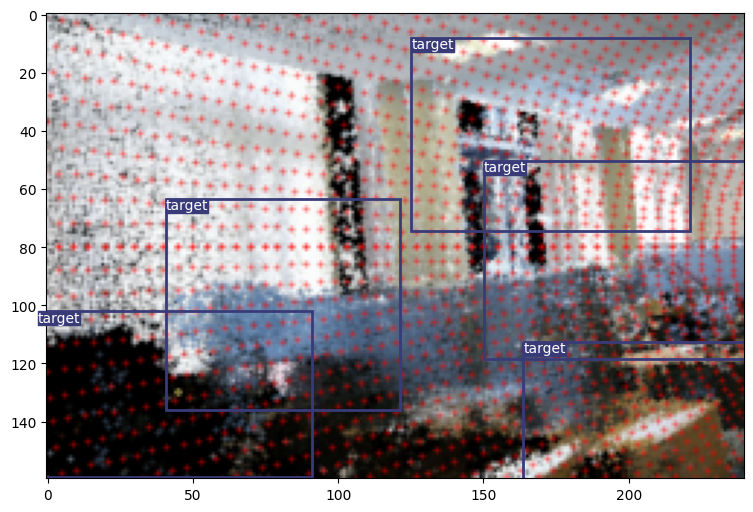

[True, True, True, True, True, True, True, True, True, True, True]


In [110]:
gbl_resetcount = 0                  # Reset count for any point detection issues
gbl_iou = 0.2                       # Global iou threshold
gbl_thresh = 0.2                    # Global bbox threshold  

gbl_angle = np.array([0, 0, 0])     # Initial angle and global variable used
gbl_pos = np.array([0, 0, 0])       # Initial position and global variable used

prev_pos = np.array([])             # Previous position store for fallback
stop_check = -1                     # Stop check for checking for new points

## -- Collection loop
while not np.all(spheres_collected):
    count = sum(spheres_collected)

    # Capture image & map ---------------------------------------------------------------------------------------------------

    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, gbl_angle, gbl_pos) 
    image_tensor = transform(image)                                                         # Apply transform
    image_tensor = image_tensor.unsqueeze(0).to(device)                                     # Add a batch dimension

    # Model prediction ------------------------------------------------------------------------------------------------------
    
    model.eval()                                                                            # Set model to eval mode            
    with torch.no_grad():

        # Prediction, bboxes and anchors application
        output = model(image_tensor)                                                        # Model output/prediction           
        bboxes = [[] for _ in range(image_tensor[0].shape[0])]                              # Predicted bounding boxes 
        anchors = (torch.tensor(ANCHORS)*torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(device)

        # Get bounding boxes for each scale
        for i in range(3):
            batch_size, A, S, _, _ = output[i].shape
            anchor = anchors[i]
            boxes_scale_i = local_utility.convert_cells_to_bboxes(output[i], anchor, s=S, is_predictions=True)
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx]+=box 

    # Applying non-max suppression to remove overlapping bounding boxes -----------------------------------------------------
    
    for i in range(batch_size):
        nms_boxes = local_utility.nms(bboxes[i], iou_thresh=gbl_iou, threshold=gbl_thresh)   # Get nms boxes with thresholds
        local_utility.plot_image(image, nms_boxes)                                           # Plot results
        nboxes = len(nms_boxes)                                                              # Total number of identified boxes
        
    # Thresholding & error checking -----------------------------------------------------------------------------------------
    
    gbl_pos_selected = threshold_boxes(nms_boxes, image, gbl_pos, prev_pos)                  # Call bounding box thresholding
    
    # Check for any incorrectly identified boxes
    if nboxes==0 or abs(gbl_pos_selected[2])>13.5:        
        print("Error! No valid points detected, view adjusting. Calling correct_view()")
        gbl_pos = prev_pos                                                                   # Roll back position for recheck
        #stop_check = count
        gbl_angle = correct_view(gbl_angle)                                                  # Call angle reset
        gbl_resetcount+=1                                                                    # Update reset count
        
        continue
    
    # Update position for spheres check -------------------------------------------------------------------------------------    
    
    global_cloud, spheres_collected = PacMan.update_scene(gbl_pos_selected, spheres_collected) 
    print(spheres_collected)
    
    # Fallback check --------------------------------------------------------------------------------------------------------    

    cur = sum(spheres_collected)                                                              # Current collected spheres
    
    # Check for any new points detected following check.
    if cur==count:
        print("Error! No new points detected, view adjusting. Calling correct_view()")
        gbl_pos = prev_pos                                                                    # Roll back position for recheck
        gbl_angle = correct_view(gbl_angle)                                                   # Call angle reset
        gbl_resetcount+=1                                                                     # Update reset count
        
        continue
        
    prev_pos = gbl_pos_selected                                                               # Update previous position

## 3.3 - Results

In [111]:
count_true = sum(spheres_collected)
print("Spheres Collected:", count_true, "/11")

Spheres Collected: 11 /11
